In [1]:
import sys
sys.path.append('/nfs/homedirs/giri/masterthesis')

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from robust_priornet.utils.visualizer import plot_adv_samples, plot_all_pr_curves, plot_all_roc_curves
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.eval.model_prediction_eval import ClassifierPredictionEvaluator
from robust_priornet.attack_priornet import plot_ood_attack_success

In [3]:
model_dir="runtime-model-vgg6-50epochs"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="OMNIGLOT"

### Utils

In [6]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [16]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Eval task on train set (only 5000 images)

### OOD-detect task

In [7]:
out_dir=model_dir+"/ood-eval-train"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --train_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --train_dataset --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/ood-eval-train ./runtime-data MNIST OMNIGLOT


In [8]:
os.system(cmd)

0

### Misclassify-detect task

In [9]:
out_dir=model_dir+"/eval-train"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task misclassification_detect --train_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task misclassification_detect --train_dataset --model_dir runtime-model-vgg6-50epochs --result_dir runtime-model-vgg6-50epochs/eval-train ./runtime-data MNIST OMNIGLOT


In [10]:
os.system(cmd)

0

## Attack in-domain and eval ood-detect task on train set (same 5000 images)
### Same as previous task but the in-domain samples are transformed to adversarial samples and then evaluated for ood-detect task

### Diff entropy attack

In [5]:
out_dir=model_dir+"/attack-fgsm-train-ood"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --ood_eval --ood_dataset OMNIGLOT --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-train-ood


In [5]:
os.system(cmd)

2

#### Attack's epsilon curve - diff entropy

In [7]:
thresholds = [-12.80262] * 7
thresholds += [-12.8021] * 3

result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -12.80262, tn: 5000, fp: 0, fn: 5000, tp: 0, total: 10000
epsilon: 0.2, threshold: -12.80262, tn: 5000, fp: 0, fn: 5000, tp: 0, total: 10000
epsilon: 0.3, threshold: -12.80262, tn: 5000, fp: 0, fn: 5000, tp: 0, total: 10000
epsilon: 0.4, threshold: -12.80262, tn: 4999, fp: 1, fn: 4999, tp: 1, total: 10000
epsilon: 0.5, threshold: -12.80262, tn: 4999, fp: 1, fn: 4999, tp: 1, total: 10000
epsilon: 0.6, threshold: -12.80262, tn: 4997, fp: 3, fn: 4997, tp: 3, total: 10000
epsilon: 0.7, threshold: -12.80262, tn: 4986, fp: 14, fn: 4986, tp: 14, total: 10000
epsilon: 0.8, threshold: -12.8021, tn: 4964, fp: 36, fn: 4964, tp: 36, total: 10000
epsilon: 0.9, threshold: -12.8021, tn: 4833, fp: 167, fn: 4833, tp: 167, total: 10000
epsilon: 1.0, threshold: -12.8021, tn: 4473, fp: 527, fn: 4473, tp: 527, total: 10000


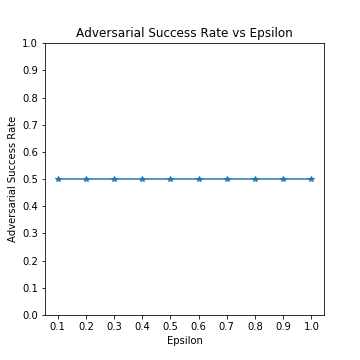

In [8]:
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve.png')))

In [10]:
# same measure before attack?
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train', 'id_differential_entropy.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train', 'ood_differential_entropy.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, -12.80262)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 5000, fp: 0, fn: 1, tp: 4999, total: 10000


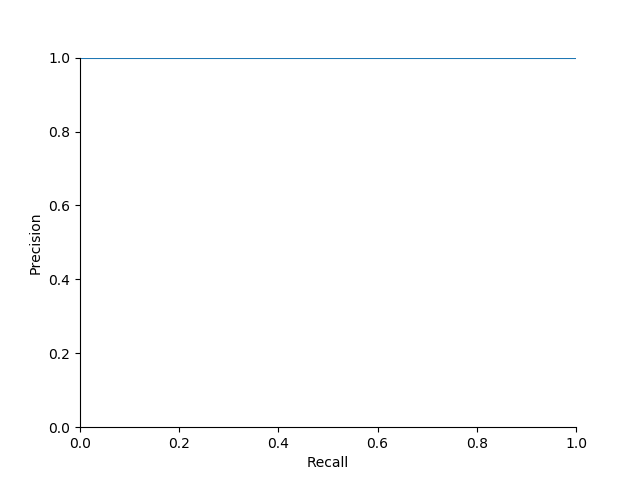

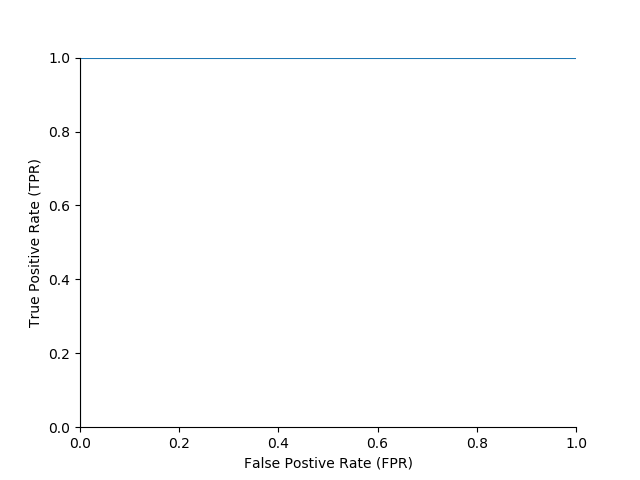

In [7]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

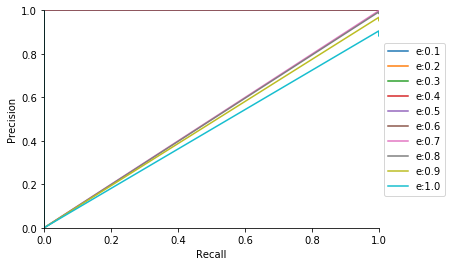

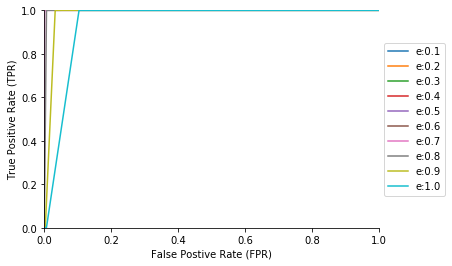

In [11]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Attack's epsilon curve - distributional uncertainty

In [5]:
thresholds = [0.3764342] * len(epsilon_list)

plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY, thresholds, out_dir, os.path.join(out_dir, 'ood-success-duncertainty'))

epsilon: 0.1, threshold: 0.3764342, tn: 4979, fp: 21, fn: 4979, tp: 21, total: 10000
epsilon: 0.2, threshold: 0.3764342, tn: 4924, fp: 76, fn: 4924, tp: 76, total: 10000
epsilon: 0.3, threshold: 0.3764342, tn: 4680, fp: 320, fn: 4680, tp: 320, total: 10000
epsilon: 0.4, threshold: 0.3764342, tn: 4354, fp: 646, fn: 4354, tp: 646, total: 10000
epsilon: 0.5, threshold: 0.3764342, tn: 3882, fp: 1118, fn: 3882, tp: 1118, total: 10000
epsilon: 0.6, threshold: 0.3764342, tn: 3176, fp: 1824, fn: 3176, tp: 1824, total: 10000
epsilon: 0.7, threshold: 0.3764342, tn: 2901, fp: 2099, fn: 2901, tp: 2099, total: 10000
epsilon: 0.8, threshold: 0.3764342, tn: 3151, fp: 1849, fn: 3151, tp: 1849, total: 10000
epsilon: 0.9, threshold: 0.3764342, tn: 3438, fp: 1562, fn: 3438, tp: 1562, total: 10000
epsilon: 1.0, threshold: 0.3764342, tn: 3560, fp: 1440, fn: 3560, tp: 1440, total: 10000


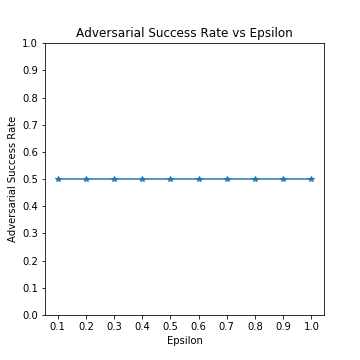

In [7]:
display(Image.open(os.path.join(out_dir, 'ood-success-duncertainty', 'epsilon-curve.png')))

In [13]:
# same measure before attack?
id_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train', 'id_distributional_uncertainty.txt'))
ood_dist_un = np.loadtxt(os.path.join(model_dir, 'ood-eval-train', 'ood_distributional_uncertainty.txt'))
y_preds = np.concatenate((id_dist_un, ood_dist_un), axis=0)
y_true = np.concatenate((np.zeros_like(id_dist_un), np.ones_like(ood_dist_un)), axis=0)
tn, fp, fn, tp = ClassifierPredictionEvaluator.compute_confusion_matrix_entries(y_preds, y_true, 0.3764342)
print(f"tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, total: {len(y_true)}")

tn: 4995, fp: 5, fn: 0, tp: 5000, total: 10000


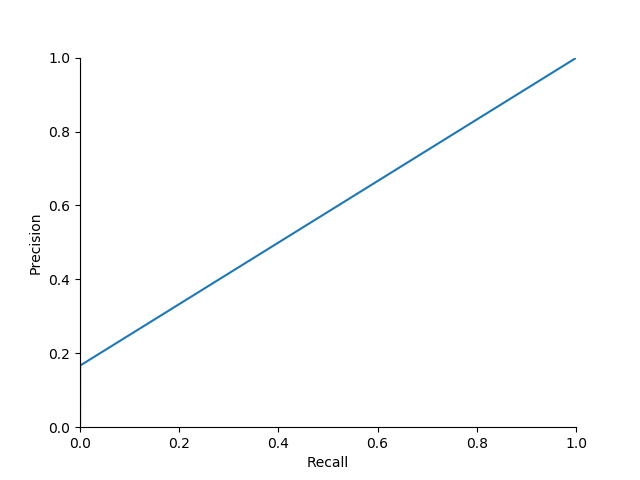

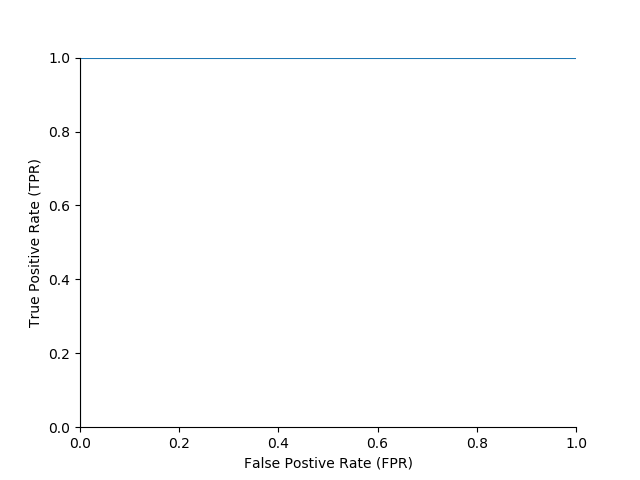

In [17]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train', UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY)

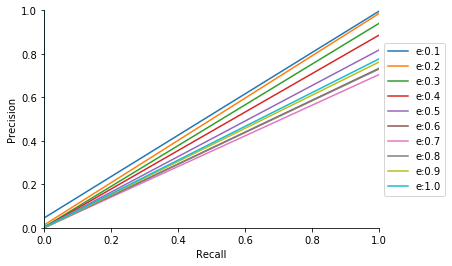

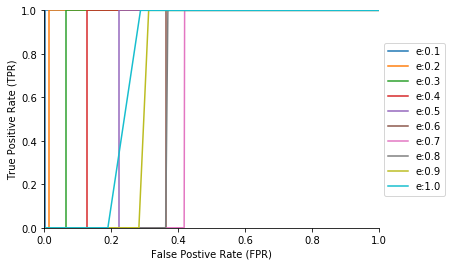

In [12]:
# model under attack
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood")
measure = UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

### Confidence attack

In [14]:
out_dir=model_dir+"/attack-fgsm-train-ood-conf"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset {ood_dataset} --dataset_size_limit 5000 --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --train_dataset --ood_eval --ood_dataset OMNIGLOT --dataset_size_limit 5000 --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs ./runtime-data MNIST runtime-model-vgg6-50epochs/attack-fgsm-train-ood-conf


In [15]:
os.system(cmd)

0

#### Attack's epsilon curve

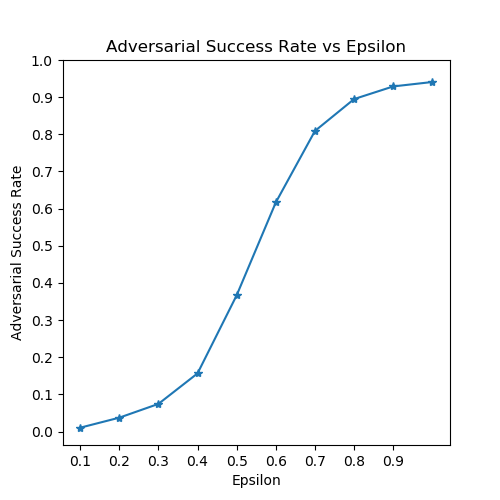

In [16]:
display(Image.open(os.path.join(out_dir, 'epsilon-curve.png')))

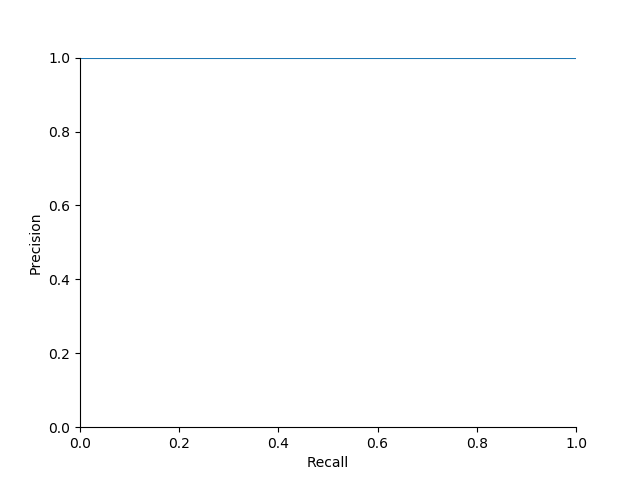

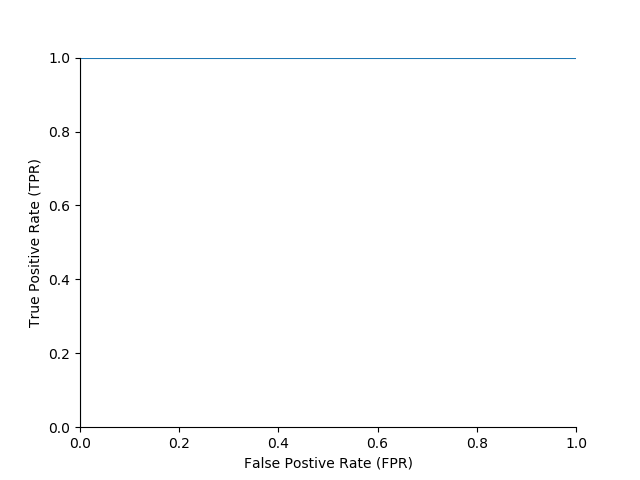

In [17]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train', UncertaintyMeasuresEnum.CONFIDENCE)

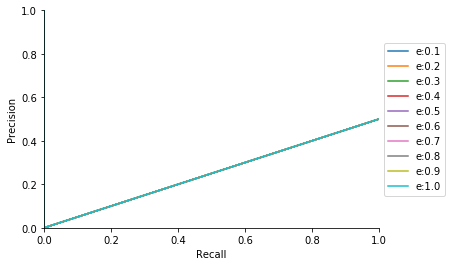

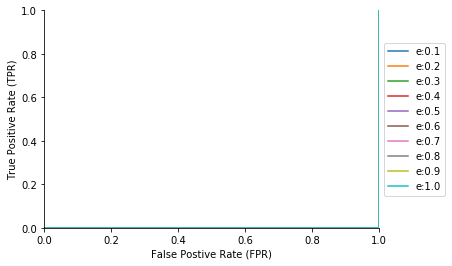

In [18]:
# model under attack - confidence
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

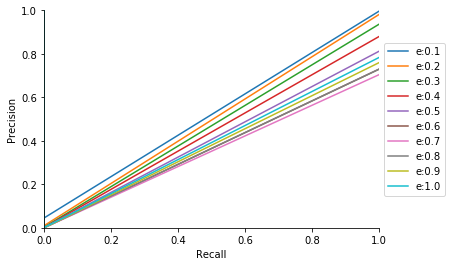

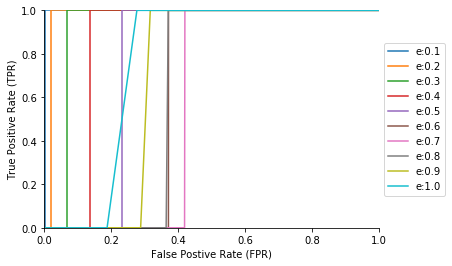

In [19]:
# model under attack - distributional uncertainty
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf")
measure = UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

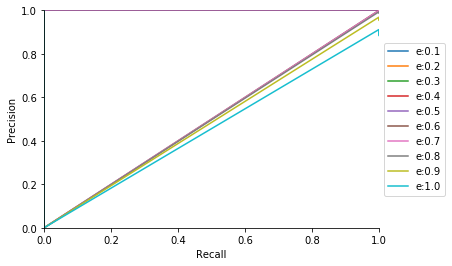

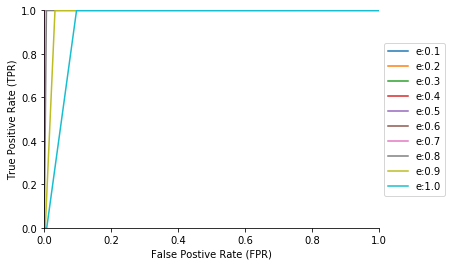

In [20]:
# model under attack - differential entropy
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

## Adversarial images (Diff entropy attack)

### TODO: Plot In domain wrongly classified as OOD and vice versa as adverarial samples for OOD attack

# Misclassified samples under attack:  4552
# Correct classified samples prior attack:  4999
# Real adversarial samples under attack:  4551


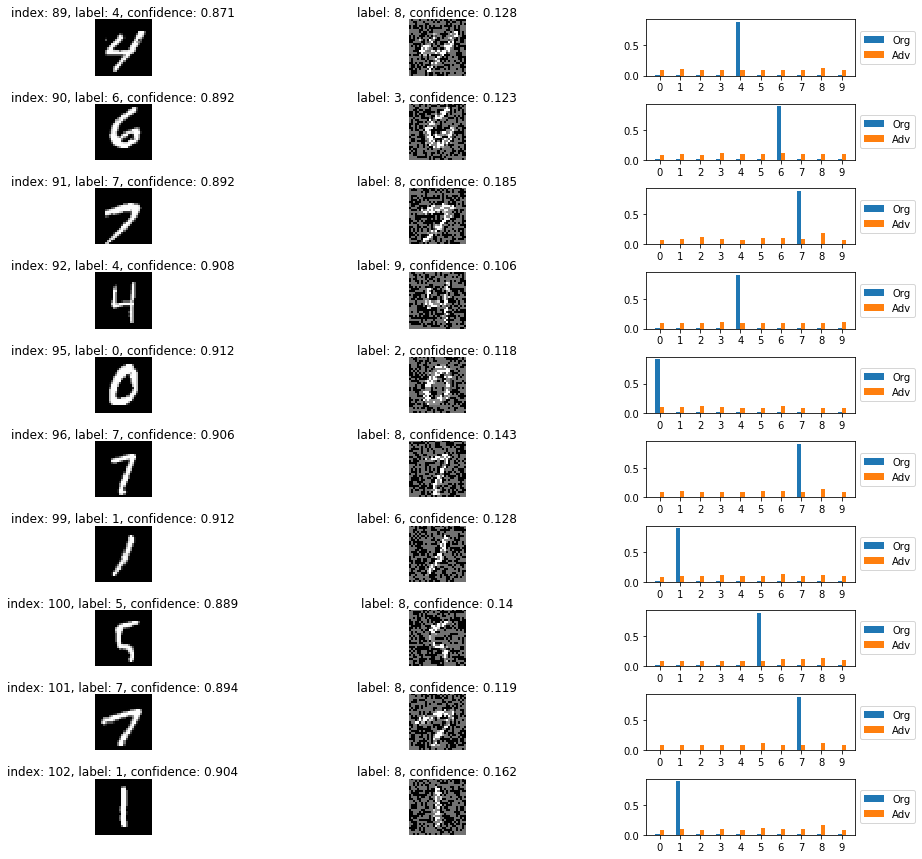

In [21]:
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood")
org_eval_dir=os.path.join(model_dir, "eval-train")
create_vis_plots(org_eval_dir, attack_dir, 0.9, limit=100)

## Adversarial images (Confidence attack)

# Misclassified samples under attack:  1131
# Correct classified samples prior attack:  4999
# Real adversarial samples under attack:  1130


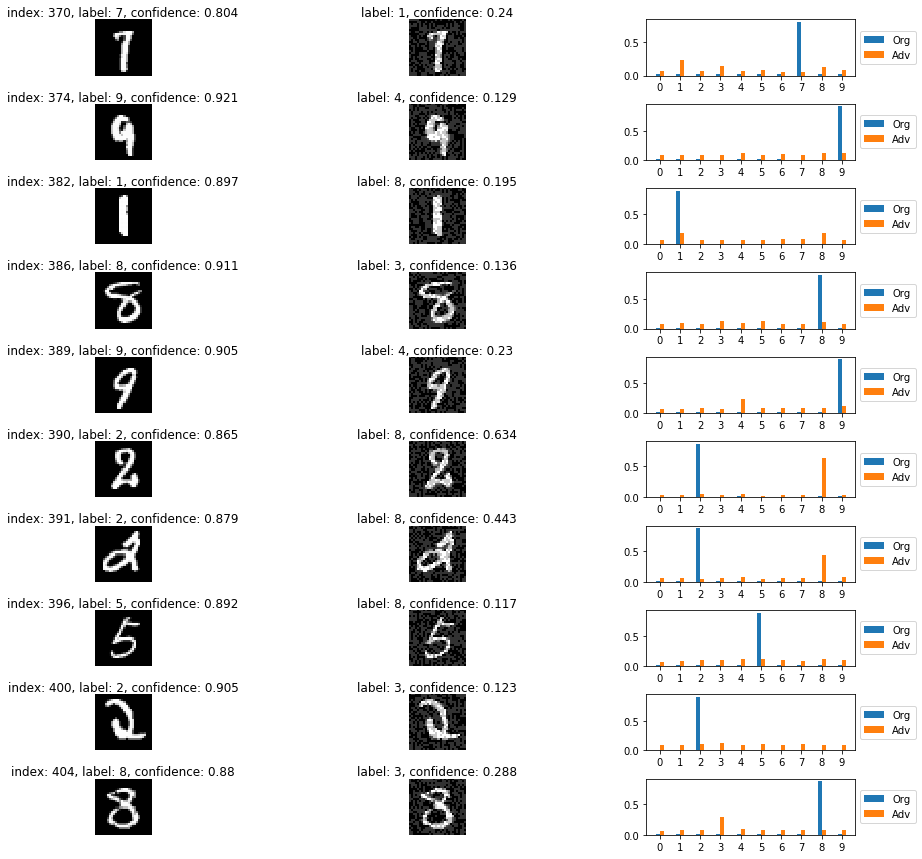

In [22]:
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-conf")
org_eval_dir=os.path.join(model_dir, "eval-train")
create_vis_plots(org_eval_dir, attack_dir, 0.4, limit=100)